# Traffic lights classifier

In [3]:
%matplotlib inline
from collections import Counter, namedtuple

import numpy as np

import os.path
import shutil
import zipfile
import time
from glob import glob

import tensorflow as tf
import warnings
from tqdm import tqdm
from urllib.request import urlretrieve
from distutils.version import LooseVersion
import matplotlib.pyplot as plt


## Definitions

In [23]:
# Alphabetical order (Keras generator friendly)
classes = ['green', 'none', 'red', 'yellow']

## Load data

In [17]:
def show_images(data, ncols=4, labels=None):
    """ Display images.
    """
    nrows = np.ceil(len(data) / ncols)
    for ii in range(len(data)):
        plt.subplot(nrows, ncols, ii + 1)
        if labels is not None:
            plt.title(labels[ii][:30])
        plt.imshow(data[ii].squeeze(), cmap=plt.cm.Greys_r)
    plt.tight_layout()


def show_random_images(data, nsamples=16, ncols=4, labels=None):
    """ Display random images.
    """
    idxs = np.random.randint(0, len(data), nsamples)
    show_images(data[idxs], ncols, labels=labels[idxs] if labels is not None else None)

In [21]:
def load_images(dir, label):
    images = np.array([plt.imread(f) for  f in glob(os.path.join(dir, label, '*.jpg'))])
    print('"{}" loaded: {}'.format(label, images.shape))
    return images

def load_all_images(dir, labels):
    all_imgs = []
    all_labels = []
    for i, l in enumerate(labels):
        imgs = load_images(dir, l)
        all_imgs.append(imgs)
        all_labels.append(np.full(len(imgs), i))
    return (np.concatenate(all_imgs), np.concatenate(all_labels))

In [5]:
X_train, y_train = load_all_images('./data/img_simulator/train/', classes)
print('Total: {}'.format(X_train.shape))           

"green" loaded: (688, 600, 800, 3)
"none" loaded: (986, 600, 800, 3)
"red" loaded: (718, 600, 800, 3)
"yellow" loaded: (215, 600, 800, 3)
Total: (2607, 600, 800, 3)


Labels shape: (2607,)
[0 0 0 0 0 0 0 0 0 0]


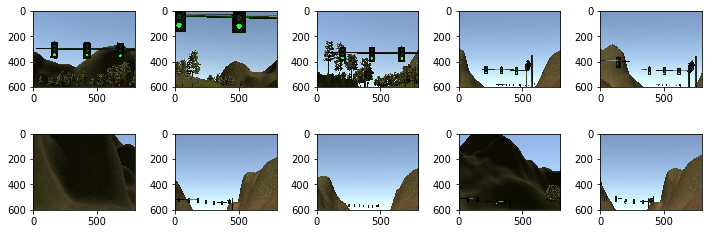

In [9]:
print('Labels shape: {}'.format(y_train.shape))
print(y_train[:10])

plt.figure(figsize=(10, 4))
show_images(X_train[:10], 5)
plt.tight_layout()

## Transfer learning classifier (VGG-16)

In [19]:
# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion(
    '1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn(
        'No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [9]:
import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers.pooling import GlobalMaxPool2D
from keras.layers import Dense, Dropout
from keras.models import Model
from keras import backend as be

be.clear_session()

# input_tensor=in, input_shape=(448, 448, 3),

base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')

x = base_model.output
x = Dense(256, activation='relu')(x)
x = Dropout(.5)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(.5)(x)
predictions = Dense(4, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False    

optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'], )

In [10]:
image_datagen_train = keras.preprocessing.image.ImageDataGenerator(zoom_range=0.1, 
                                                                   shear_range=0.1, 
                                                                   channel_shift_range=.05, 
                                                                   rotation_range=5,                                                                    
                                                                  )
image_generator_train = image_datagen_train.flow_from_directory(    
    './data/img_simulator/train/', 
    batch_size=16,
    target_size=(300, 400),
    shuffle=True)

image_datagen_val = keras.preprocessing.image.ImageDataGenerator()
image_generator_val = image_datagen_val.flow_from_directory(    
    './data/img_simulator/validation/', 
    batch_size=16,
    target_size=(300, 400),
    shuffle=True)

# y_train_one_hot = keras.utils.to_categorical(y_train, num_classes=4)
model.fit_generator(image_generator_train,
                    steps_per_epoch = 2600/16, 
                    validation_data = image_generator_val, 
                    validation_steps= 10,                                                            
                    epochs=10,
                    shuffle=True,
                    class_weight={0: 2, 1: 1, 2: 1, 3: 4}
                    )

Found 2607 images belonging to 4 classes.
Found 237 images belonging to 4 classes.
Epoch 1/10
163/162 [==============================] - 47s - loss: 1.6196 - acc: 0.7215 - val_loss: 0.4492 - val_acc: 0.9125
Epoch 2/10
163/162 [==============================] - 45s - loss: 0.5769 - acc: 0.8830 - val_loss: 0.5825 - val_acc: 0.8599
Epoch 3/10
163/162 [==============================] - 46s - loss: 0.3854 - acc: 0.9237 - val_loss: 0.4542 - val_acc: 0.9108
Epoch 4/10
163/162 [==============================] - 46s - loss: 0.2991 - acc: 0.9436 - val_loss: 0.3761 - val_acc: 0.9062
Epoch 5/10
163/162 [==============================] - 46s - loss: 0.2931 - acc: 0.9409 - val_loss: 0.4486 - val_acc: 0.8981
Epoch 6/10
163/162 [==============================] - 46s - loss: 0.2189 - acc: 0.9544 - val_loss: 0.4379 - val_acc: 0.9108
Epoch 7/10
163/162 [==============================] - 46s - loss: 0.2266 - acc: 0.9567 - val_loss: 0.4066 - val_acc: 0.9125
Epoch 8/10
163/162 [=============================

In [32]:
with open(file='model.yaml', mode='w') as f:
    f.write(model.to_yaml())

In [33]:
model.save_weights('./weights.h5')

## Load model

In [34]:
from keras.models import model_from_yaml
with open('model.yaml', 'r') as f:
    model = model_from_yaml(f.read());
model.load_weights('weights.h5')

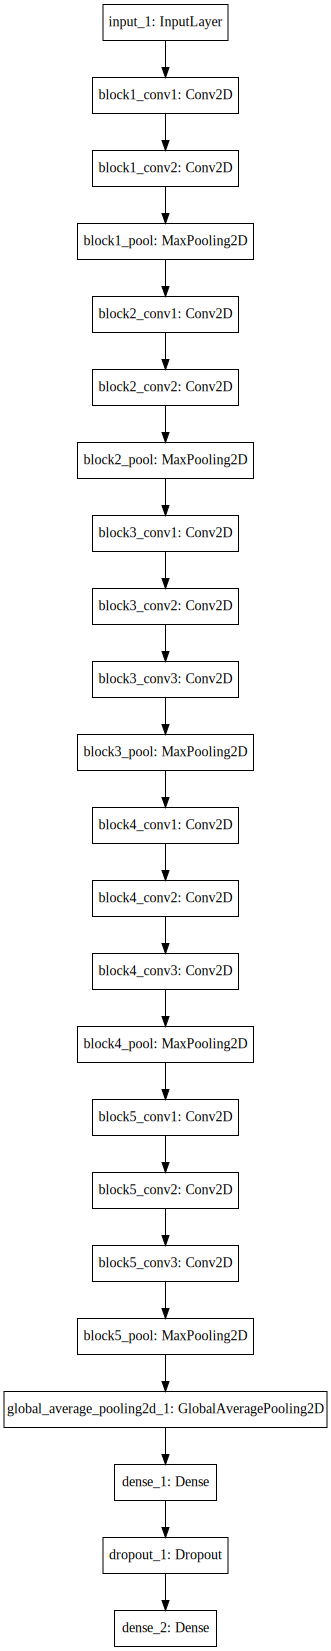

In [35]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

"green" loaded: (40, 600, 800, 3)
"none" loaded: (142, 600, 800, 3)
"red" loaded: (40, 600, 800, 3)
"yellow" loaded: (15, 600, 800, 3)
[2 3 3 3 0 3 3 3 0 3 3 3 3 3 3 3]
[2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


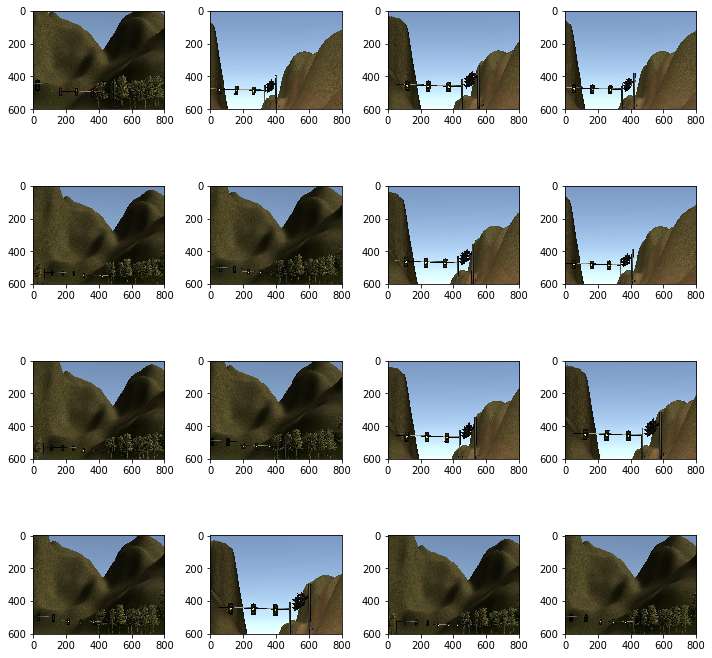

In [45]:
X_val, y_val = load_all_images('./data/img_simulator/validation/', classes)

plt.figure(figsize=(10, 10))
show_images(X_val[-16:])

print(np.argmax(model.predict(X_val[-16:]), axis=-1))
print(y_val[-16:])